## 🔰PyTorchでニューラルネットワーク基礎 #16 【時系列・因果畳み込み】

### 内容
* Qiitaの記事と連動しています。
* 因果畳み込みを利用して港区可燃ごみの収集量を予測する回帰問題の演習を行う。
* データはminatoku_gomi.csvを利用します。

### データについて
* 港区オープンデータカタログサイト
* [港区のごみ収集量【速報値】](https://opendata.city.minato.tokyo.jp/dataset/gomishushu)
* 2013年〜2022年：月次データ

### 出典と加工
* 出典：港区オープンデータカタログサイト
* [港区のごみ収集量【速報値】](https://opendata.city.minato.tokyo.jp/dataset/gomishushu)
* 2025年8月1日に利用
* 港区のごみ収集量データからごみの種類（可燃ごみ、不燃ごみ、粗大ごみ、管路収集）と月データに抽出加工して作成 

### 概要
* 因果畳み込みを利用して可燃ごみと月から、翌月の可燃ごみ収集量を予測

### データの読み込み
* 可燃ごみと月のデータのみ利用
* 窓サイズは３
* 入力データの形状は、（バッチサイズ、チャンネル数＝２、系列長＝３）の形

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/minatoku_gomi.csv",index_col="年月")
data.head()

,種類,収集量,月
年月,,,
2013-04,可燃ごみ,4053.99,4
2013-04,不燃ごみ,208.90,4
2013-04,粗大ごみ,179.21,4
2013-04,管路収集,175.37,4
2013-05,可燃ごみ,4107.33,5


In [3]:
scaling_factor = 1_000
kanen = data[data["種類"]=="可燃ごみ"]["収集量"]/scaling_factor
month = data[data["種類"]=="可燃ごみ"]["月"]
kanen_list = kanen.to_list()
month_list = month.to_list()

win_size = 3  # 入力データの窓サイズ
x0 = [kanen_list[i:i+win_size] for i in range(len(kanen_list)-win_size)]
x1 = [month_list[i:i+win_size] for i in range(len(month_list)-win_size)]
x0 = np.array(x0)
x1 = np.array(x1)

t = kanen_list[win_size:]

### torchテンソルへ変換・学習用データとテスト用データに分割


In [6]:
import torch
import torch.nn as nn

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")


x0 = torch.FloatTensor(x0).reshape(x0.shape[0], 1, x0.shape[1]).to(device)
x1 = torch.FloatTensor(x1).reshape(x1.shape[0], 1, x1.shape[1]).to(device)
x  = torch.cat([x0,x1], dim=1)
t = torch.FloatTensor(t).view(-1,1).to(device)


period = 20
x_train = x[:-period]
x_test = x[-period:]
t_train = t[:-period]
t_test = t[-period:]

x_train.shape, x_test.shape, t_train.shape, t_test.shape

device: cuda


(torch.Size([96, 2, 3]),
 torch.Size([20, 2, 3]),
 torch.Size([96, 1]),
 torch.Size([20, 1]))

### ネットワーク構造
* CausalConv1dクラスを作成
* DNNクラスが全体のネットワーク

In [8]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=self.dilation)

    def forward(self, x):
        h = self.conv(x)
        return h[:, :, :-self.padding]

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 特徴量の抽出       
        self.causal_layers = nn.Sequential(
            CausalConv1d(in_channels=2, out_channels=10, kernel_size=3),
            nn.ReLU(),
            CausalConv1d(in_channels=10, out_channels=10, kernel_size=3),
            nn.ReLU(),
            CausalConv1d(in_channels=10, out_channels=10, kernel_size=3)
        )
        # 回帰分析のレイヤー　10チャンネルｘ３（データの系列長）
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10*3, out_features=1)
        )
        
    def forward(self, x):
        h = self.causal_layers(x)
        y = self.regressor(h)
        
        return y

In [9]:
model = DNN().to(device)

### torchinfoライブラリを利用してネットワーク構造を表示

In [10]:
from torchinfo import summary
summary(model, (1,2,3))

Layer (type:depth-idx)                   Output Shape              Param #
DNN                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 10, 3]                --
│    └─CausalConv1d: 2-1                 [1, 10, 3]                --
│    │    └─Conv1d: 3-1                  [1, 10, 5]                70
│    └─ReLU: 2-2                         [1, 10, 3]                --
│    └─CausalConv1d: 2-3                 [1, 10, 3]                --
│    │    └─Conv1d: 3-2                  [1, 10, 5]                310
│    └─ReLU: 2-4                         [1, 10, 3]                --
│    └─CausalConv1d: 2-5                 [1, 10, 3]                --
│    │    └─Conv1d: 3-3                  [1, 10, 5]                310
├─Sequential: 1-2                        [1, 1]                    --
│    └─Flatten: 2-6                      [1, 30]                   --
│    └─Linear: 2-7                       [1, 1]                    31
Total params:

In [11]:
criterion = nn.MSELoss() 
optimizer = torch.optim.AdamW(model.parameters())

In [12]:
LOOP = 3000

In [13]:
model.train()
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x_train)
    loss = criterion(y,t_train)
    if (epoch+1)%200 == 0:
        print(epoch,"\tloss:", loss.item())
    loss.backward()
    optimizer.step()

199 	loss: 0.09067292511463165
399 	loss: 0.06064325571060181
599 	loss: 0.05330036208033562
799 	loss: 0.04577476903796196
999 	loss: 0.03685494512319565
1199 	loss: 0.027998391538858414
1399 	loss: 0.023001668974757195
1599 	loss: 0.02104346454143524
1799 	loss: 0.01975562423467636
1999 	loss: 0.018626466393470764
2199 	loss: 0.017617149278521538
2399 	loss: 0.016791708767414093
2599 	loss: 0.016312554478645325
2799 	loss: 0.015969937667250633
2999 	loss: 0.01564794033765793


## 検証
* テスト用データ (x_test) を使い、予測結果をグラフにしてみる

In [14]:
model.eval()
with torch.inference_mode():
    pred = model(x_test)
pred=pred.cpu().detach().numpy()


real = t_test.detach().cpu().numpy()

pred.shape

(20, 1)

In [15]:
# ナイーブ予測の1期前の実測値なのでtrainの最後とtestをつなげて作成
naive = torch.cat([t_train[-1].view(-1,1), t_test[:-1]], dim=0).cpu().detach().numpy()

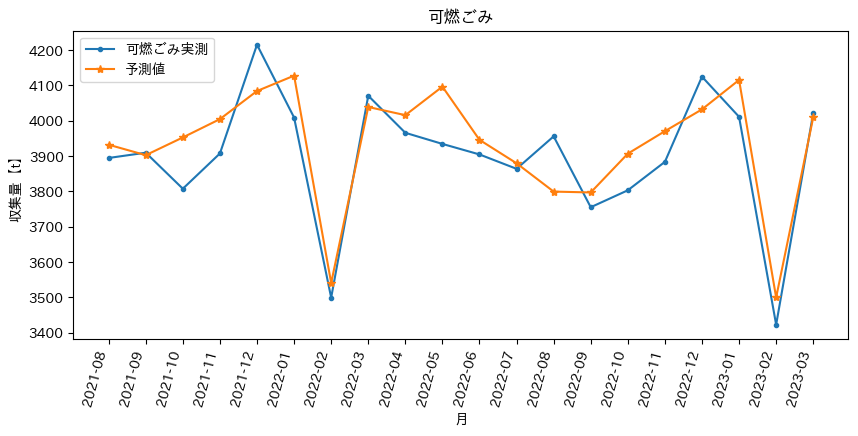

In [16]:
import matplotlib.pyplot as plt
import japanize_matplotlib

s=x_train.shape[0]

plt.figure(figsize=(10,4))

plt.plot(kanen.index.values[win_size+s:], real*scaling_factor, label="可燃ごみ実測", marker=".")
plt.plot(kanen.index.values[win_size+s:], pred*scaling_factor,  label="予測値", marker="*")
#plt.plot(kanen.index.values[win_size+s:], naive*scaling_factor, label="ナイーブ", linestyle="dotted")

plt.xticks(rotation=75, ha='right')
plt.title("可燃ごみ")
plt.xlabel("月")
plt.ylabel("収集量【t】")
plt.legend()
plt.show()


## 前年同月データで確認

In [29]:
# 前年同月データの抽出
smly =np.array(kanen[-20-12:-12])
smly.shape

(20,)

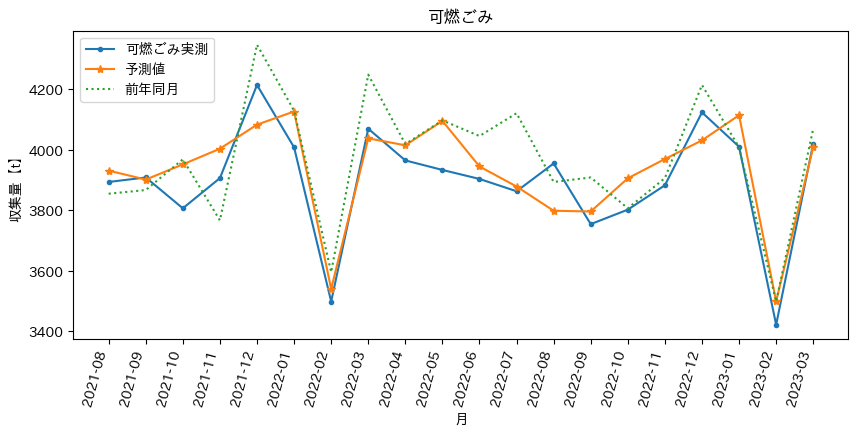

In [30]:
import matplotlib.pyplot as plt
import japanize_matplotlib

s=x_train.shape[0]

plt.figure(figsize=(10,4))

plt.plot(kanen.index.values[win_size+s:], real*scaling_factor, label="可燃ごみ実測", marker=".")
plt.plot(kanen.index.values[win_size+s:], pred*scaling_factor,  label="予測値", marker="*")
plt.plot(kanen.index.values[win_size+s:], smly*scaling_factor, label="前年同月", linestyle="dotted")

plt.xticks(rotation=75, ha='right')
plt.title("可燃ごみ")
plt.xlabel("月")
plt.ylabel("収集量【t】")
plt.legend()
plt.show()
